Paper: "Women’s Preferences for Treatment of Perinatal Depression and Anxiety: A Discrete Choice Experiment"

Author(s): Jemimah Ride, Emily Lancsar

Year: 2016

Model(s): Multinomial Logit, Mixed Logit

Main findings: \_\_\_\_

# Import needed libraries

In [1]:
import sys
from collections import OrderedDict

import scipy.stats

import numpy as np
import pandas as pd

import seaborn as sbn
import matplotlib.pyplot as plt

from statsmodels.formula.api import logit

sys.path.insert(0, '/Users/timothyb0912/Documents/pylogit/')
import pylogit as pl

sys.path.insert(0, '../../src/')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Import data

In [2]:
data_path =\
    '../../data/raw/ride_2016/ride_2016_data.dta'
df = (pd.read_stata(data_path)
        .sort_values(['id', 'cset', 'alt']))
# df = (pd.read_stata(data_path))

# Look at data

In [3]:
df.shape

(10416, 50)

In [4]:
df.id.unique().size

217

In [5]:
df.head().T

41  \
choice                                                1   
alt                                                   A   
id                                                  101   
cset                                                  1   
block                                                 2   
preg                                 Currently pregnant   
post                 Has not had baby in last 12 months   
lact                        not currently breastfeeding   
age                                                  26   
educ                                           postgrad   
employ                                   paid mat leave   
country                                               1   
lang                                            English   
married                                   live together   
children                                              0   
income                                  $156000 or more   
phi                                             has phi   
hcc                                   does not have hcc   
support                                           a lot   
pastcouns                                                 
pastmeddep                                                
pastmedanx                                                
pastmedpsy                                                
pasmbu                                                    
pastinpt                                                  
pastherb                                                  
pastepc                                                   
pastgrp                                                   
pastyoga                                                  
pastpeer                                                  
pastnone                                              Y   
pastsleepmedication                                       
helpseek                                              N   
IRDdecile                                            10   
ASC                                                   1   
cost                                                  0   
effect                                                1   
child                                                 0   
med                                                   0   
combo                                                 0   
group                                                 0   
peer                                                  0   
herb                                                  0   
MYE                                                   1   
epc                                                   0   
couns                                                 0   
home                                                  1   
phone                                                 0   
online                                                0   
clinic                                                0   

                                                     43  \
choice                                                0   
alt                                                   B   
id                                                  101   
cset                                                  1   
block                                                 2   
preg                                 Currently pregnant   
post                 Has not had baby in last 12 months   
lact                        not currently breastfeeding   
age                                                  26   
educ                                           postgrad   
employ                                   paid mat leave   
country                                               1   
lang                                            English   
married                                   live together   
children                                              0   
income                                  $156000 or more   
phi                                     

In [6]:
set(df.columns.tolist())

{'ASC',
 'IRDdecile',
 'MYE',
 'age',
 'alt',
 'block',
 'child',
 'children',
 'choice',
 'clinic',
 'combo',
 'cost',
 'couns',
 'country',
 'cset',
 'educ',
 'effect',
 'employ',
 'epc',
 'group',
 'hcc',
 'helpseek',
 'herb',
 'home',
 'id',
 'income',
 'lact',
 'lang',
 'married',
 'med',
 'online',
 'pasmbu',
 'pastcouns',
 'pastepc',
 'pastgrp',
 'pastherb',
 'pastinpt',
 'pastmedanx',
 'pastmeddep',
 'pastmedpsy',
 'pastnone',
 'pastpeer',
 'pastsleepmedication',
 'pastyoga',
 'peer',
 'phi',
 'phone',
 'post',
 'preg',
 'support'}

In [7]:
# How many individuals are in the dataset?
df.id.unique().size

217

In [8]:
# How many choice sets per person?
df.cset.unique().size

16

# Clean data

In [9]:
# Give names to the alternatives
alt_id_map = {'A': 1, 'B': 2, 'N':3}
alt_id_reverse_map = {alt_id_map[k]: k for k in alt_id_map}

In [10]:
# Initialize the clean datafram
clean_df = df.copy()

# Create an observation id column for each choice set
categorical_obs_ids =\
    sorted(list(set((x, y) for x, y in 
                    clean_df[['id', 'cset']].values)))
obs_id_map =\
    {k: (pos + 1) for pos, k in enumerate(categorical_obs_ids)}

def get_obs_id(series, mapping):
    decision_maker_id = series.at['id']
    choice_set_id = series.at['cset']
    key = (decision_maker_id, choice_set_id)
    return mapping[key]

clean_df['obs_id'] =\
    clean_df.apply(get_obs_id, axis=1, args=(obs_id_map,))

# Convert the alternative id column to be numeric
clean_df['alt'] = clean_df['alt'].map(alt_id_map)

# Convert the columns of explanatory variables to dummy variables
# for col in ['advantage', 'compatibility', 'simplicity',
#             'trialability', 'observability']:
#     clean_df[col] = clean_df[col].map({1: 1, -1: 0})

In [11]:
# Look at the shape of clean_df
print('clean_df.shape == {}'.format(clean_df.shape))

# Look at some records in clean_df
clean_df.head(6).T


clean_df.shape == (10416, 51)


41  \
choice                                                1   
alt                                                   1   
id                                                  101   
cset                                                  1   
block                                                 2   
preg                                 Currently pregnant   
post                 Has not had baby in last 12 months   
lact                        not currently breastfeeding   
age                                                  26   
educ                                           postgrad   
employ                                   paid mat leave   
country                                               1   
lang                                            English   
married                                   live together   
children                                              0   
income                                  $156000 or more   
phi                                             has phi   
hcc                                   does not have hcc   
support                                           a lot   
pastcouns                                                 
pastmeddep                                                
pastmedanx                                                
pastmedpsy                                                
pasmbu                                                    
pastinpt                                                  
pastherb                                                  
pastepc                                                   
pastgrp                                                   
pastyoga                                                  
pastpeer                                                  
pastnone                                              Y   
pastsleepmedication                                       
helpseek                                              N   
IRDdecile                                            10   
ASC                                                   1   
cost                                                  0   
effect                                                1   
child                                                 0   
med                                                   0   
combo                                                 0   
group                                                 0   
peer                                                  0   
herb                                                  0   
MYE                                                   1   
epc                                                   0   
couns                                                 0   
home                                                  1   
phone                                                 0   
online                                                0   
clinic                                                0   
obs_id                                                1   

                                                     43  \
choice                                                0   
alt                                                   2   
id                                                  101   
cset                                                  1   
block                                                 2   
preg                                 Currently pregnant   
post                 Has not had baby in last 12 months   
lact                        not currently breastfeeding   
age                                                  26   
educ                                           postgrad   
employ                                   paid mat leave   
country                                               1   
lang                                            English   
married                                   live together   
children                                              0   
income                                  

In [12]:
# Record the columns that denote the various treatment types
treatment_types = ['couns', 'combo', 'peer', 'group',
                   'epc', 'herb', 'MYE']
# Note the names of these variables as they should be displayed
# in the estimation results table
treatment_names =\
    ['Counseling',
     'Counseling & medication',
     'Peer support',
     'Group counseling',
     'Early parenting centre programme',
     'Natural, herbal or traditional Chinese medicine',
     'Meditation, yoga or exercise',
    ]

# Record the varioius consulatation types and the names that
# should be used for these types in the estimation results table.
consultation_types = ['home', 'phone', 'online', 'clinic']
consultation_names =\
    ['Home visit', 'Telephone', 'Online', 'Clinic visit']



# Compute needed transformations / derived features

In [13]:
# Compute the socio-demographics interacted with the alternative
# specific constant
clean_df['Age'] = clean_df['age'] * clean_df['ASC']

clean_df['Employed'] =\
    (clean_df['employ'].isin(['full time', 'part time']) * 
     clean_df['ASC'])

clean_df['Unemployed'] =\
    (clean_df['employ'].isin(['unemployed', 'student', 'unable']) *
     clean_df['ASC'])

clean_df['past_experience_any_type'] =\
    (clean_df['pastnone'] != 'Y') * clean_df['ASC']

clean_df['low_support'] =\
    (clean_df['support'] != 'a lot') * clean_df['ASC']

clean_df['seek_help'] =\
    (clean_df['helpseek'] == 'Y') * clean_df['ASC']


In [14]:
# Create a numeric income column
income_map = {'$12999 or less': 12999,
              '$13000-$25999': 19500,
              '$26000-$51999': 39000,
              '$52000-88399': 70200,
              '88400-$155999': 122200,
              '$156000 or more': 156000}
clean_df['income_numeric'] = clean_df['income'].map(income_map)

In [17]:
# Interact socio-demographics with treatment attributes
clean_df['income_times_cost'] =\
    clean_df['income_numeric'] * clean_df['cost']

clean_df['insurance_times_cost'] =\
    (clean_df['phi'] == 'has phi') * clean_df['cost']

clean_df['up_to_highschool'] =\
    clean_df['educ'].isin(['less than high school',
                           'Completed high school',
                           '7'])
highschool_treatment_types =\
    [x + '_highschool' for x in treatment_types]
highschool_treatment_names =\
    [x + ' (Highschool)' for x in treatment_names]
for new_col in highschool_treatment_types:
    orig_col = new_col[:new_col.find('_highschool')]
    clean_df[new_col] =\
        clean_df['up_to_highschool'] * clean_df[orig_col]

breastfeeding_treatment_types =\
    [x + '_breastfeeding' for x in treatment_types]
breastfeeding_treatment_names =\
    [x + ' (Breastfeeding)' for x in treatment_names]
for new_col in breastfeeding_treatment_types:
    orig_col = new_col[:new_col.find('_breastfeeding')]
    clean_df[new_col] =\
        ((clean_df['lact'] == 'currently breastfeeding') *
         clean_df[orig_col])

pregnant_treatment_types =\
    [x + '_pregnant' for x in treatment_types]
pregnant_treatment_names =\
    [x + ' (Pregnant)' for x in treatment_names]
for new_col in pregnant_treatment_types:
    orig_col = new_col[:new_col.find('_pregnant')]
    clean_df[new_col] =\
        ((clean_df['preg'] == 'Currently pregnant') *
         clean_df[orig_col])


In [18]:
# Determine if a person has had prior combination treatment
clean_df['past_medication'] =\
    ((clean_df['pastmedanx'] == 'Y') |
     (clean_df['pastmeddep'] == 'Y')).astype(int)
clean_df['past_combo'] =\
    (clean_df['past_medication'] * clean_df['pastcouns'] )

# Map each treatment type to it's corresponding "past" variable
past_to_treatment_map =\
    {'couns': 'pastcouns',
     'combo': 'past_combo',
     'peer': 'pastpeer',
     'group': 'pastgrp',
     'epc': 'pastepc',
     'herb': 'pastherb',
     'MYE': 'pastyoga',
     'med': 'past_medication',
    }
# Determine whether each row corresponds to a choice situation
# where an individual has been assigned a treatment type they
# have previous experience with
clean_df['prior_experience_of_treatment_type'] = 0
current_col = 'prior_experience_of_treatment_type'
for row_pos, row in viz.PROGRESS(clean_df.iterrows(),
                                 total=clean_df.shape[0]):
    for col in treatment_types + ['med']:
        past_col = past_to_treatment_map[col]
        if (row.at[col] == 1) and (row.at[past_col] == 1):
            row.at[current_col] = 1

100%|██████████| 10416/10416 [00:02<00:00, 3998.83it/s]


# Questions:
- Have I correctly defined the following variables?:
    - `past_experience_any_type`
    - `past_combo`
    - `past_medication`
    - `prior_experience_of_treatment_type`
    - `income_numeric`

# Define the model specification and parameter names

In [23]:
explanatory_vars =\
    (['ASC'] +
     treatment_types +
     ['cost',
      'effect'] +
     consultation_types +
     ['child',
      'Age',
      'Employed',
      'Unemployed',
      'past_experience_any_type',
      'low_support',
      'seek_help',
      'income_times_cost',
      'insurance_times_cost',
      'prior_experience_of_treatment_type',
     ] +
     highschool_treatment_types +
     breastfeeding_treatment_types +
     pregnant_treatment_types
    )

display_names =\
    (['Alternative Specific Constant'] +
     treatment_names +
     ['Medication cost',
      'Likely to improve'] +
     consultation_types +
     ['Childcare available',
      'Age',
      'Employed',
      'Unemployed',
      'Experience of any treatment type',
      'Low support ;eve;s',
      'States would seek help',
      'Income * Cost',
      'Private health insurance * Cost',
      'Experience of matched treatment type',
     ] +
     highschool_treatment_names +
     breastfeeding_treatment_names +
     pregnant_treatment_names
    )

missing_vars =\
    [x for x in explanatory_vars if x not in clean_df.columns]
if len(missing_vars) > 0:
    msg = 'These explanatory variables are not in the data file:'
    raise ValueError(msg + '\n{}'.format(missing_vars))

assert len(display_names) == len(explanatory_vars)
# Populate the specification and name dictionaries
class SpecInfo(object):
    def __init__(self,
                 variable_list,
                 display_names):
        self.variable_list = variable_list
        self.name_list = display_names
        self.spec_dict = OrderedDict()
        self.name_dict = OrderedDict()
        
        self.populate_spec_and_name_dicts()
        return None
        
    def populate_spec_and_name_dicts(self):
        num_vars = len(self.variable_list)
        for pos in range(num_vars):
            current_column = self.variable_list[pos]
            self.spec_dict[current_column] = 'all_same'
            self.name_dict[current_column] = self.name_list[pos]
        return None

base_model_info = SpecInfo(explanatory_vars, display_names)

# Set model parameters

In [24]:
# This column denotes whether the row's alternative was chosen
choice_col = 'choice'
# This column denotes the alternative corresponding to the row
alt_id_col = 'alt'
# This column denotes the id of the row's unique choice situation
obs_id_col = 'obs_id'

# Create the model object(s)

In [25]:
model_obj =\
    pl.create_choice_model(
        data=clean_df,
        alt_id_col=alt_id_col,
        obs_id_col=obs_id_col,
        choice_col=choice_col,
        specification=base_model_info.spec_dict,
        model_type='MNL',
        names=base_model_info.name_dict)

# Estimate and view the model

In [26]:
model_obj.fit_mle(np.zeros(len(display_names)))
model_obj.get_statsmodels_summary()

Log-likelihood at zero: -3,814.3819
Initial Log-likelihood: -3,814.3819


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -2,839.2914


LinAlgError: singular matrix

# <font color='darkred'> Current Status
All is broken. Cannot reproduce original results. It is unclear what steps were taken to estimate the first model.

# Set checking parameters

In [15]:
NUM_SAMPLES = 200
RANDOM_SEED = 100

np.random.seed(RANDOM_SEED)

# Sample from the posterior or approximate sampling distribution of model parameters

In [16]:
class CheckingObject(object):
    def __init__(self, pylogit_obj, num_samples, seed=None):
        # Set object attributes
        self.model = pylogit_obj
        self.hessian = pylogit_obj.hessian
        self.asym_cov = pylogit_obj.cov
        self.asym_dist =\
            scipy.stats.multivariate_normal(
                mean=pylogit_obj.params, cov=self.asym_cov)
        self.posterior_probs = None
        self.sim_y = None
        
        # Set the random seed, if desired
        if seed is not None:
            np.random.seed(seed)

        # Get and set the posterior parameter samples
        self.param_samples = self.asym_dist.rvs(num_samples)
        # Compute and set the posterior probabilities
        self.compute_posterior_probs()
        # Compute and set the simulated choices
        self.simulate_choices()
        return None
        
    def compute_posterior_probs(self):
        self.posterior_probs =\
            self.model.predict(self.model.data,
                               param_list=[self.param_samples.T,
                                           None, None, None])
        return None

    def simulate_choices(self):
        self.sim_y =\
            viz.simulate_choice_vector(
                self.posterior_probs,
                self.model.data[self.model.obs_id_col].values)
        return None

In [17]:
model_checker =\
    CheckingObject(model_obj, NUM_SAMPLES, seed=RANDOM_SEED)

Simulating Choices: 100%|██████████| 1600/1600 [00:00<00:00, 13333.00it/s]


# Generate posterior predictive datasets

# Save all model generated data

In [18]:
# Save posterior parameter samples

# Save posterior predictive datasets

# Determine the measurement scales of the variables to be checked 

In [19]:
# Declare which variables are to be checked
variables_to_check = (explanatory_vars + 
                      ['age',
                       'edulevel',
                       'gender',
                       'hospital',
                       'place',
                       'workyr',
                      ])

In [20]:
print('Number of unique values per column:')
unique_values_per_variable =\
    clean_df[variables_to_check].agg(
        lambda x: x.unique().size, axis='index')
    
print(unique_values_per_variable)

Number of unique values per column:
advantage        2
compatibility    2
simplicity       2
trialability     2
observability    2
moment           2
age              5
edulevel         3
gender           2
hospital         3
place            3
workyr           6
dtype: int64


In [21]:
# Determine a threshold for which variables will be treated as 
# continuous and which variables will be treated as categorical.
categorical_threshold = 10

# Determine which variables are continuous and which are not
continuous_variables =\
    (unique_values_per_variable[unique_values_per_variable >
                                categorical_threshold]
                               .index.tolist())

categorical_variables =\
    (unique_values_per_variable[unique_values_per_variable <=
                                categorical_threshold]
                               .index.tolist())

# <font color=darkred> Should place all checking related cells in a second notebook.</font>

# Perform the desired posterior predictive checks of the interaction model

### 1. Predictive Performance plots

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


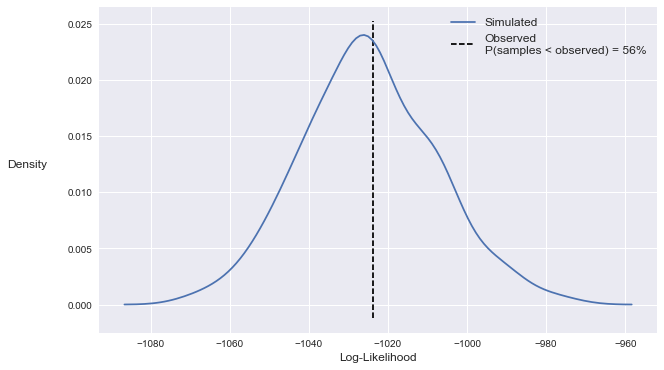

In [22]:
# Generate the simulated log-likelihoods
sim_log_likes =\
    viz.compute_prior_predictive_log_likelihoods(
        model_checker.sim_y,
        clean_df,
        choice_col,
        model_checker.model)

# Plot the simulated versus observed log-likelihood
log_like_path = None
viz.plot_predicted_log_likelihoods(sim_log_likes,
                                   model_checker.model.llf,
                                   output_file=log_like_path)

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


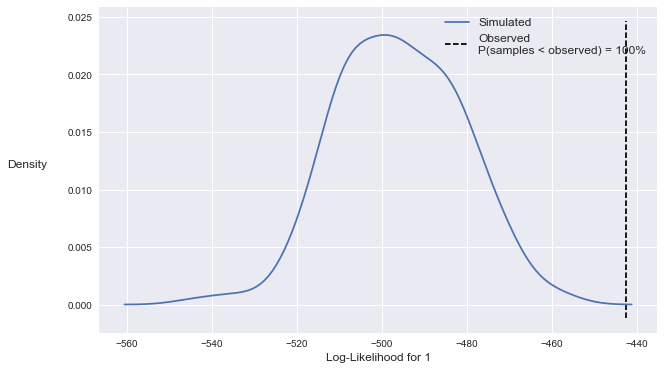

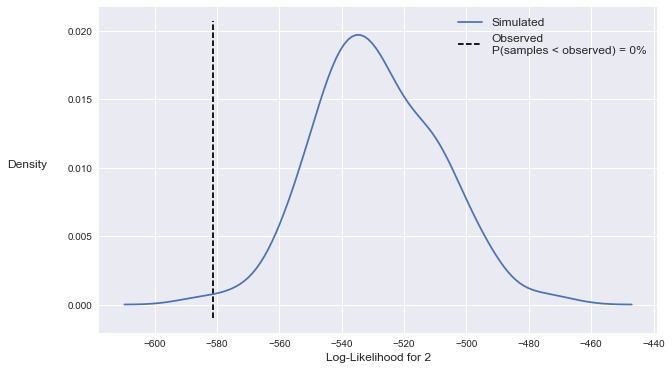

In [23]:
# Plot the simulated versus observed log-likelihood for each
# alternative
log_like_path = None
for alt_id in np.sort(clean_df[alt_id_col].unique()):
    alt_idx = clean_df[alt_id_col] == alt_id

    current_sim_y = model_checker.sim_y[alt_idx, :]
    current_obs_y = model_checker.model.choices[alt_idx]

    current_probs =\
        model_checker.model.long_fitted_probs[alt_idx]

    current_sim_log_likes =\
        current_sim_y.T.dot(np.log(current_probs))

    current_log_likelihood =\
        current_obs_y.dot(np.log(current_probs))

    current_alt_label = alt_id_reverse_map[alt_id]

    current_x_label =\
        'Log-Likelihood for {}'.format(current_alt_label)

    viz.plot_predicted_log_likelihoods(current_sim_log_likes,
                                       current_log_likelihood,
                                       x_label=current_x_label,
                                       output_file=log_like_path)

### 2. Outcome Boxplot

Unique x-values: 100%|██████████| 2/2 [00:00<00:00, 243.75it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


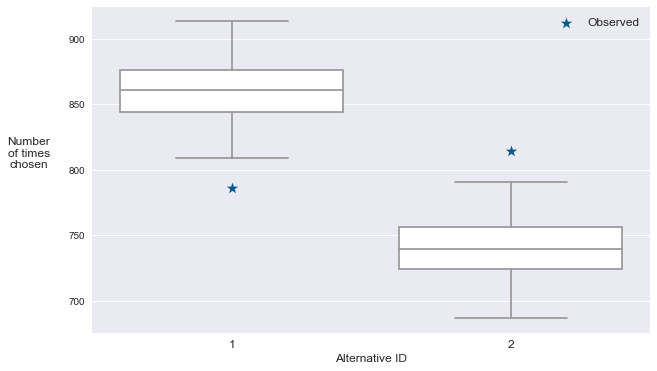

In [24]:
market_path = None
num_obs = model_checker.model.nobs


viz.plot_simulated_market_shares(
    clean_df[alt_id_col].values,
    model_checker.sim_y,
    model_checker.model.choices,
    x_label='Alternative ID',
    y_label='Number\nof times\nchosen',
    output_file=market_path)

### 3. Binned Reliability Plot

Plotting: 100%|██████████| 1/1 [00:00<00:00, 111.23it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1/1 [00:00<00:00, 307.41it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


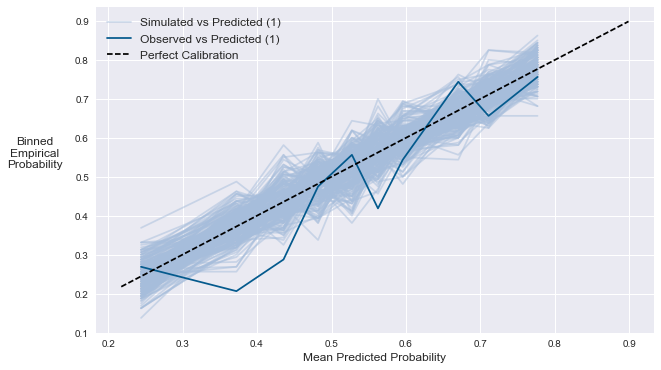

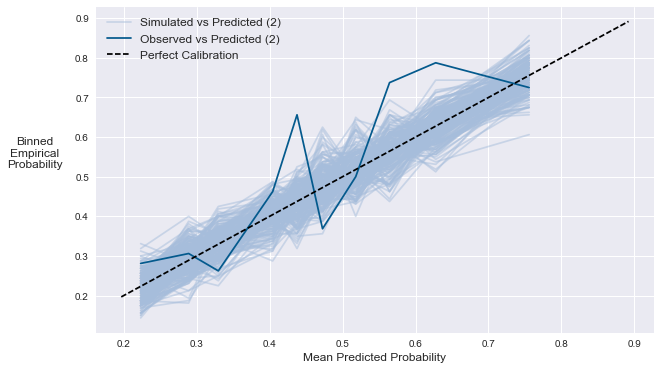

In [25]:
reload(viz)
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.model.long_fitted_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed vs Predicted ({})'.format(current_alt)
    current_sim_label =\
        'Simulated vs Predicted ({})'.format(current_alt)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    viz.plot_binned_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=None)

### 4. 'Bagged' Reliability Plot

Plotting: 100%|██████████| 200/200 [00:31<00:00,  6.60it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:30<00:00,  6.58it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a

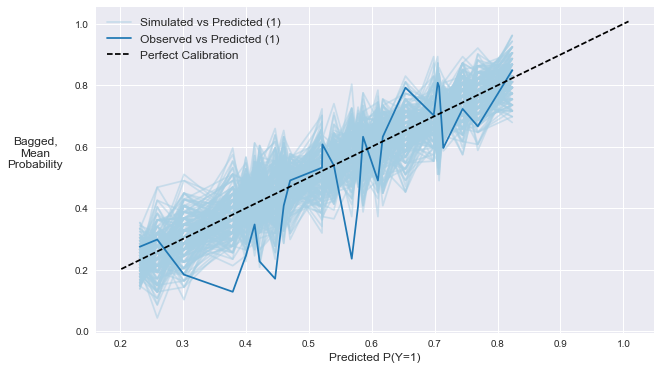

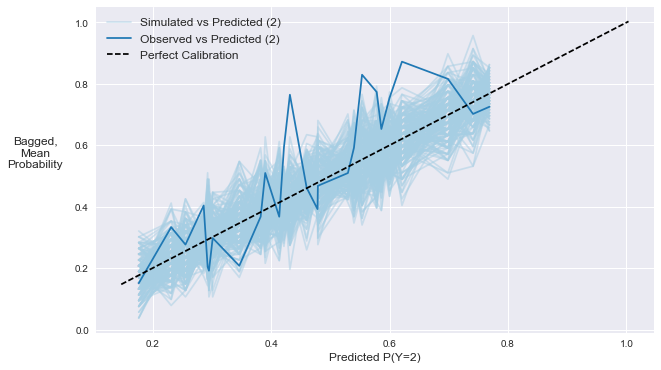

In [26]:
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.model.long_fitted_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed vs Predicted ({})'.format(current_alt)
    current_sim_label =\
        'Simulated vs Predicted ({})'.format(current_alt)

    filename = None

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    fig_and_ax = [fig, ax]
    viz.make_bagged_marginal_model_plot(
        current_sim_y,
        current_choices,
        current_probs,
        y_label=current_line_label,
        prob_label=current_sim_label,
        x_label='Predicted P(Y={})'.format(current_alt),
        alpha=0.5,
        fig_and_ax=fig_and_ax,
        output_file=filename)

    # Determine the maximum value of the x-axis or y-axis
    max_ref_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_ref_val = max(ax.get_xlim()[0], ax.get_ylim()[0])
    # Determine the values to use to plot the reference line
    ref_vals = np.linspace(min_ref_val, max_ref_val, num=100)
    # Plot the reference line as a black dashed line
    ax.plot(ref_vals, ref_vals, 'k--', label='Perfect Calibration')
    ax.legend(loc='best', fontsize=12)
    # Show the plot
    fig.show();

### 5. Binned marginal model plots

In [27]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.model.long_fitted_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed P(Y={})'.format(current_alt)
    current_sim_label =\
        'Simulated P(Y={})'.format(current_alt)
    current_predicted_label =\
        'Predicted P(Y={})'.format(current_alt)
    for col in continuous_variables:
        current_x = clean_df.loc[current_filter, col].values
    
        viz.make_binned_marginal_model_plot(
            current_probs,
            current_choices,
            current_x,
            partitions=10,
            sim_y=current_sim_y,
            y_label=current_line_label,
            prob_label=current_predicted_label,
            sim_label=current_sim_label,
            x_label=col,
            alpha=0.5,
            figsize=(10, 6),
            output_file=filename)

### 6. Bagged marginal model plots

#### 6a. Check the relationships with the raw explanatory variables

In [28]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.model.long_fitted_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_line_label =\
        'Observed P(Y={})'.format(current_alt)
    current_sim_label =\
        'Simulated P(Y={})'.format(current_alt)
    current_predicted_label =\
        'Predicted P(Y={})'.format(current_alt)
    for col in continuous_variables:
        current_x = clean_df.loc[current_filter, col].values

        viz.make_bagged_marginal_model_plot(
            current_probs,
            current_choices,
            current_x,
            sim_y=current_sim_y,
            y_label=current_line_label,
            prob_label=current_predicted_label,
            sim_label=current_sim_label,
            x_label=col,
            alpha=0.5,
            figsize=(10, 6),
            output_file=filename)

#### 6b. Check the relationship with the estimated index, $V = X \beta$

Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.45it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:29<00:00,  6.39it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


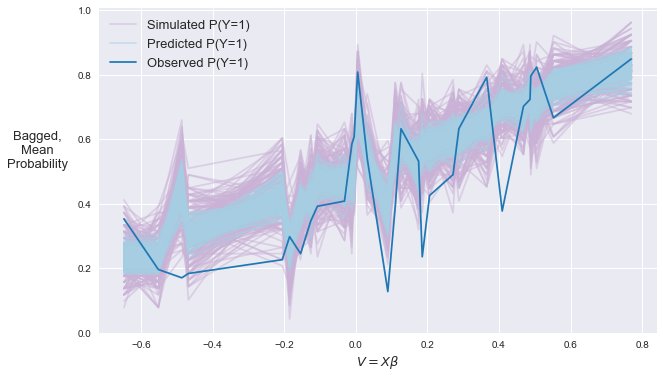

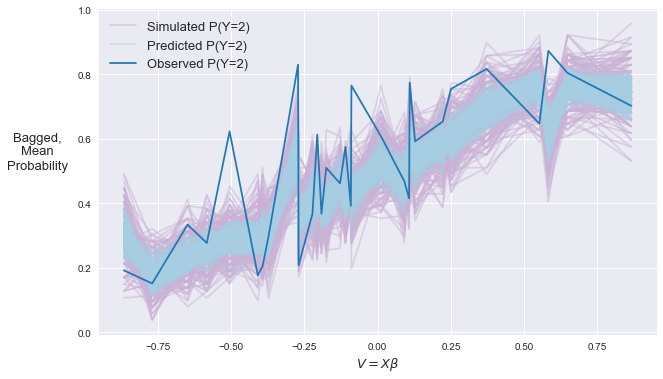

In [29]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    
    current_filter = model_checker.model.alt_IDs == alt
    current_probs =\
        model_checker.posterior_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_alt = alt_id_reverse_map[alt]
    current_x =\
        model_checker.model.design.dot(
         model_checker.model.params)[current_filter]
        
    current_y_label = 'Observed P(Y={})'.format(current_alt)
    current_prob_label = 'Predicted P(Y={})'.format(current_alt)
    current_sim_label = 'Simulated P(Y={})'.format(current_alt)

    viz.make_bagged_marginal_model_plot(
        current_probs,
        current_choices,
        current_x,
        sim_y=current_sim_y,
        y_label=current_y_label,
        prob_label=current_prob_label,
        sim_label=current_sim_label,
        x_label=r'$V = X \beta$',
        alpha=0.5,
        figsize=(10, 6),
        fontsize=13,
        output_file=filename)

### 7. Simulated KDEs

In [30]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_title = ''

    for col in continuous_variables:
        viz.plot_simulated_kde_traces(
            model_checker.sim_y,
            clean_df,
            current_filter,
            col,
            choice_col,
            label='Simulated {}'.format(col),
            title=current_title,
            figsize=(10, 6),
            output_file=filename)

### 8. Simulated CDFs

In [31]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    current_title = ''

    for current_col in continuous_variables:
        viz.plot_simulated_cdf_traces(
            iteraction_checker.sim_y,
            clean_df,
            current_filter,
            current_col,
            choice_col,
            label='Simulated ({})'.format(col),
            title=current_title,
            figsize=(10, 6),
            output_file=filename)

### 9. Simulated Histograms

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matp

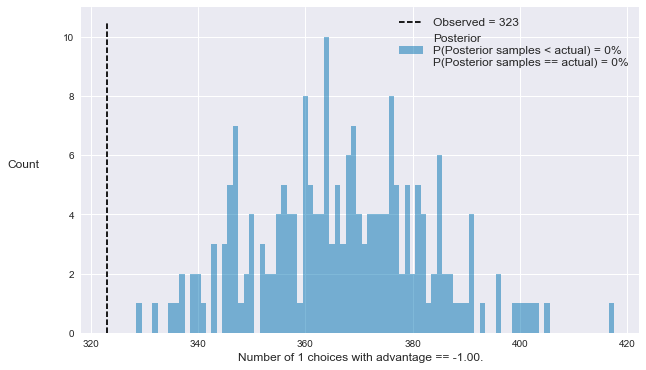

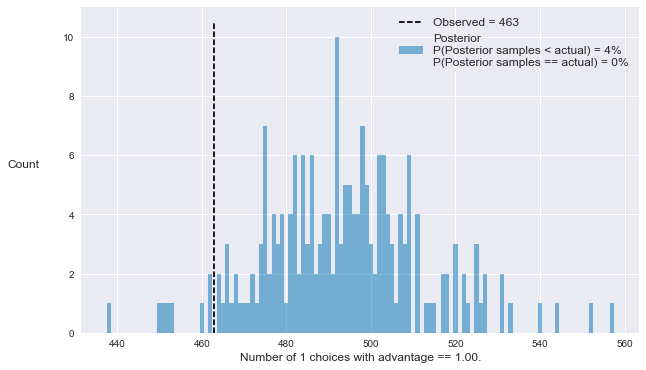

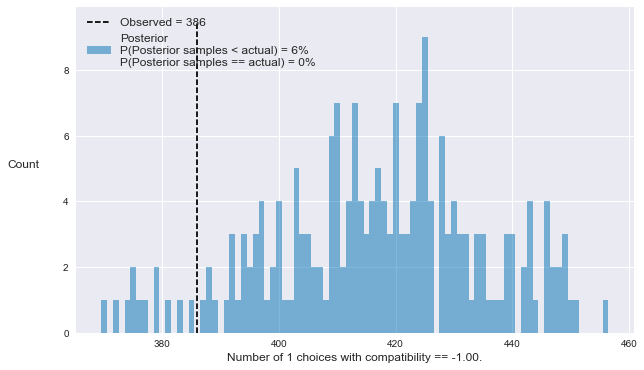

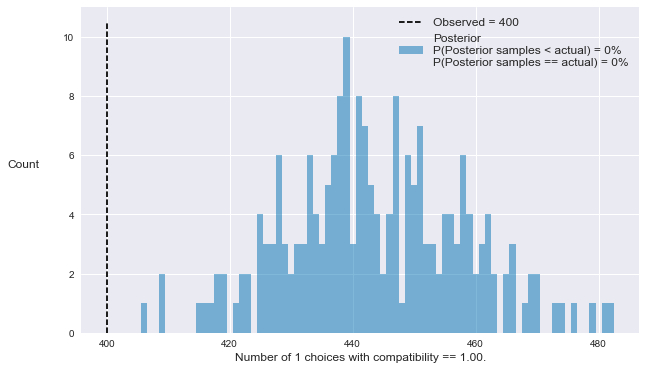

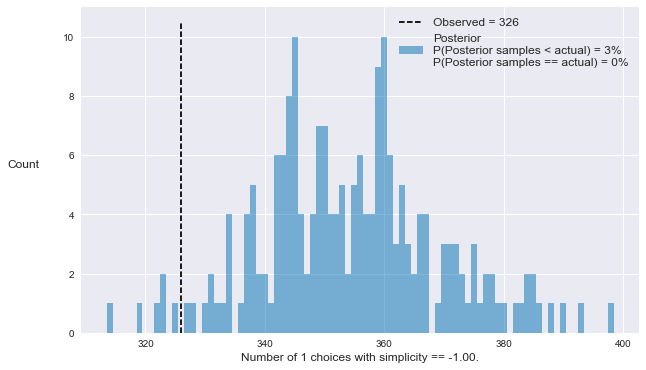

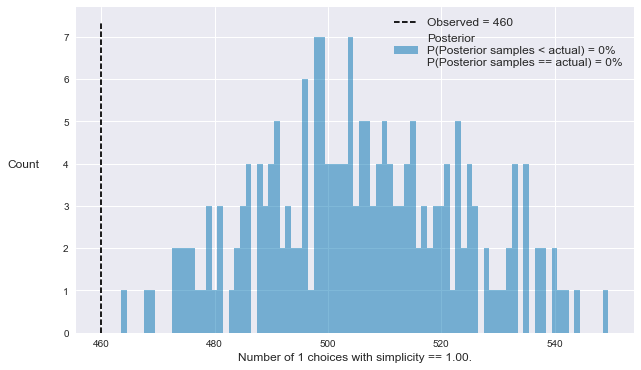

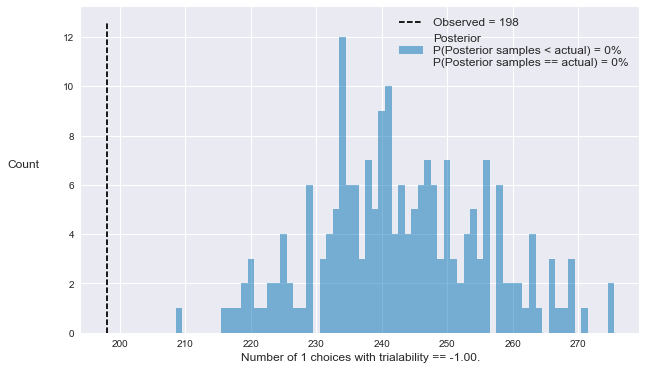

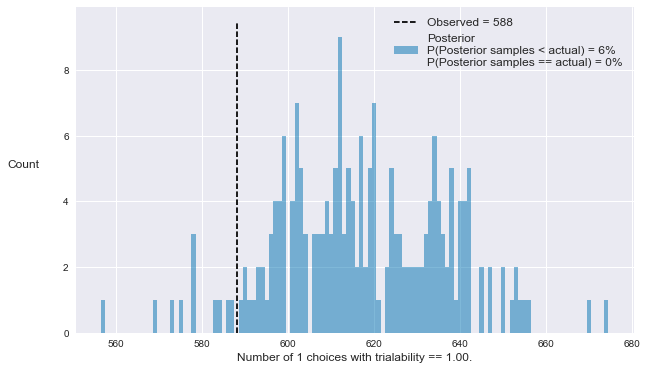

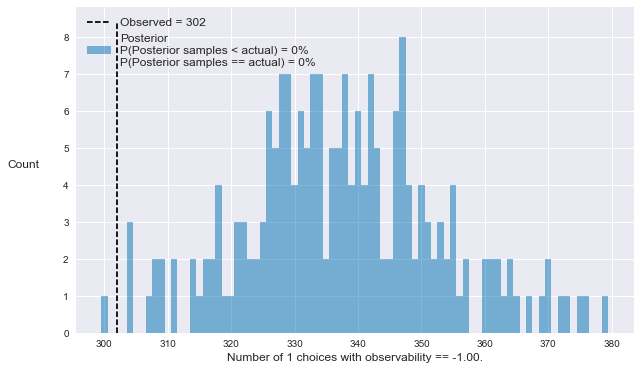

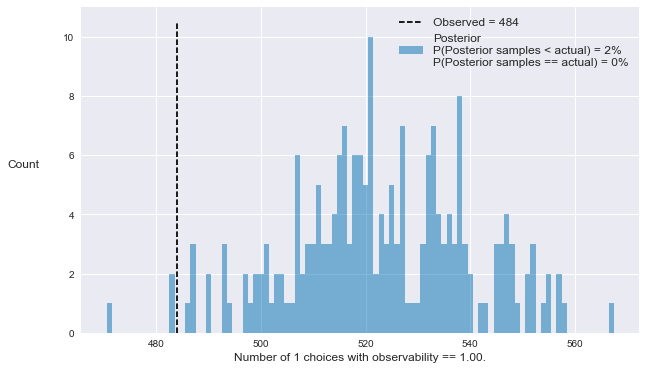

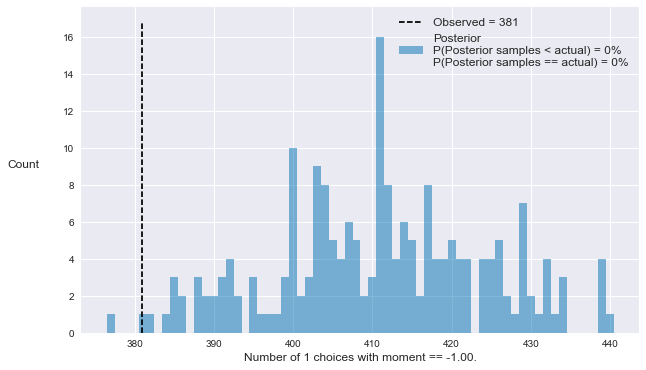

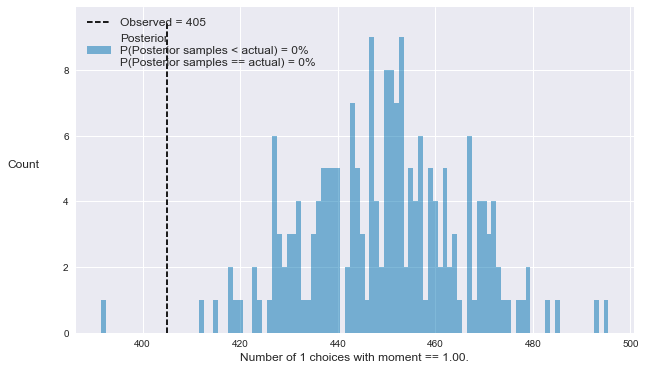

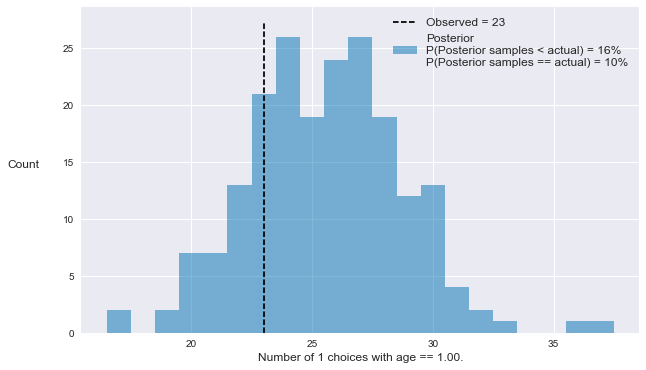

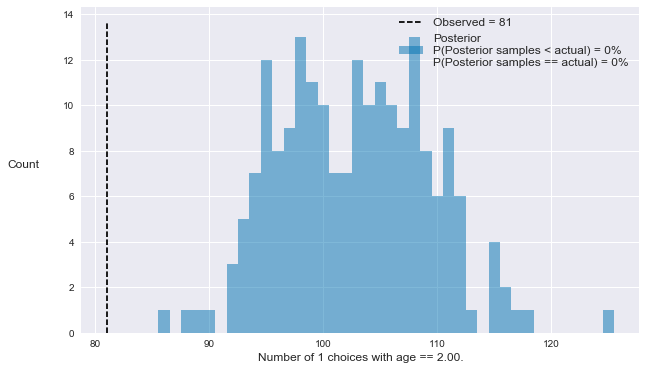

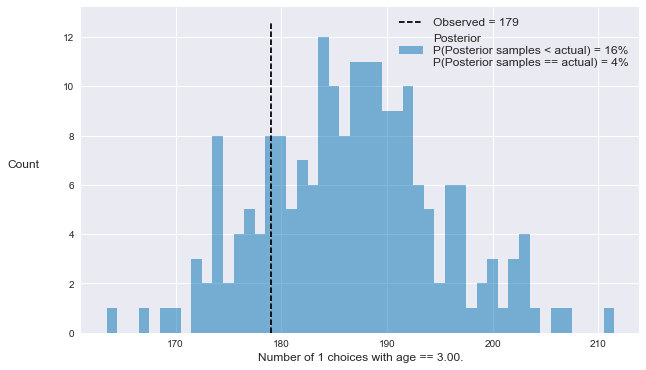

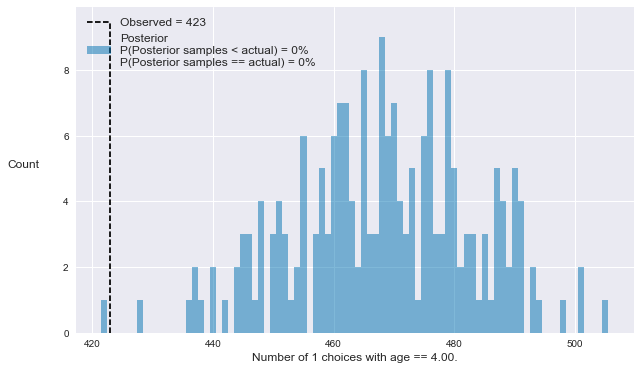

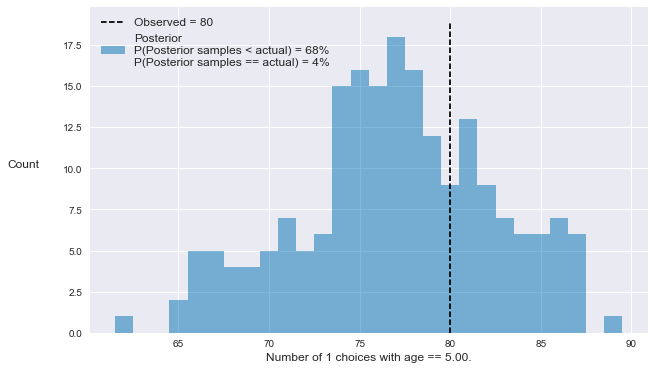

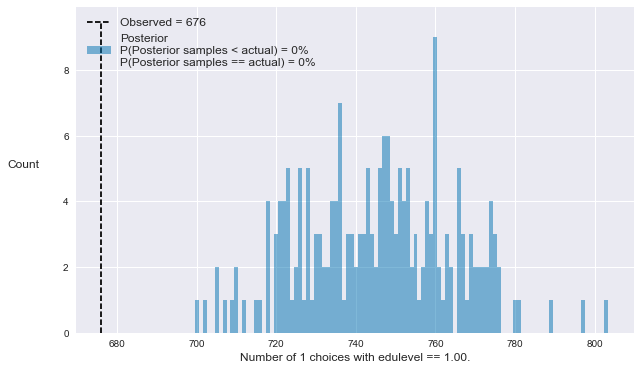

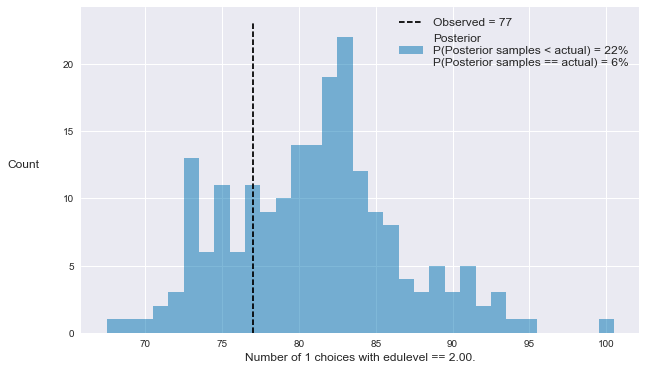

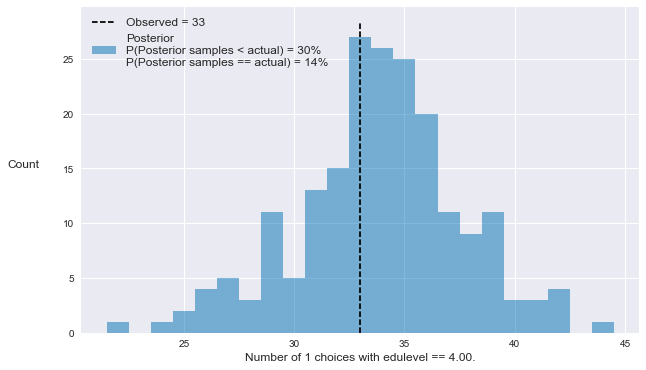

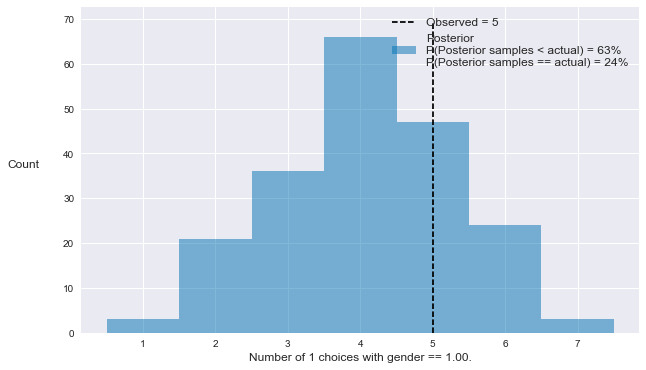

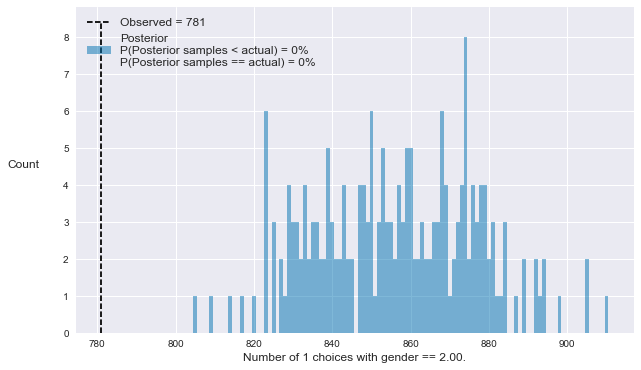

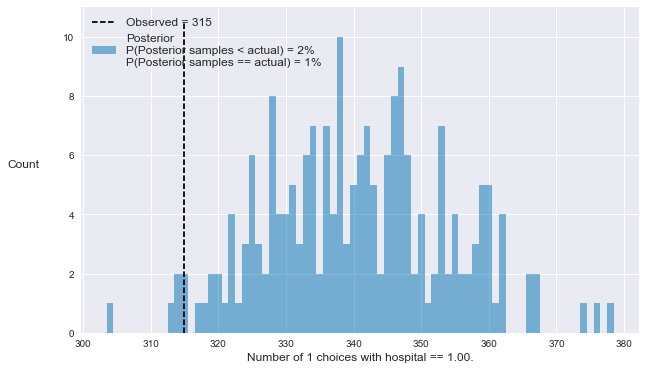

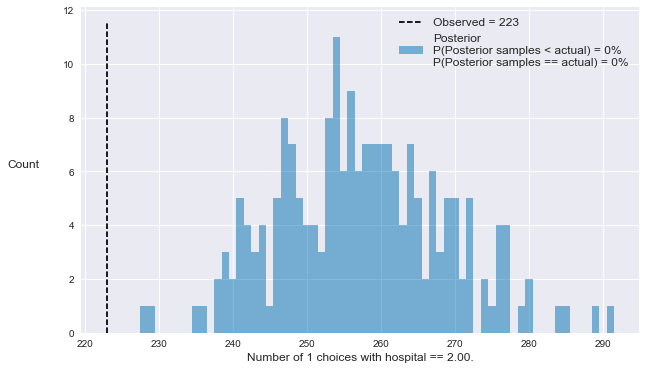

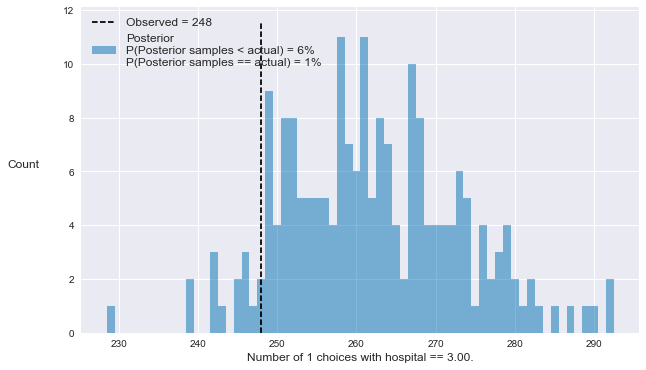

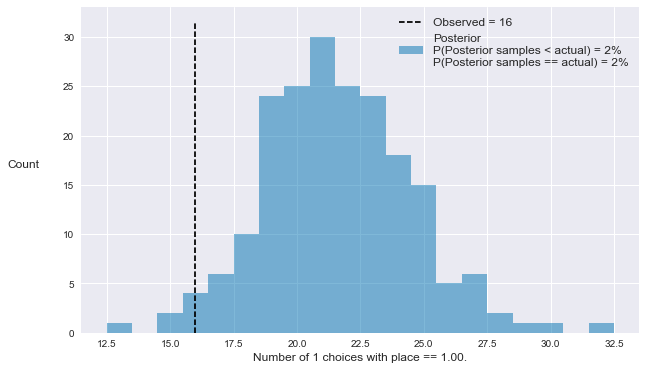

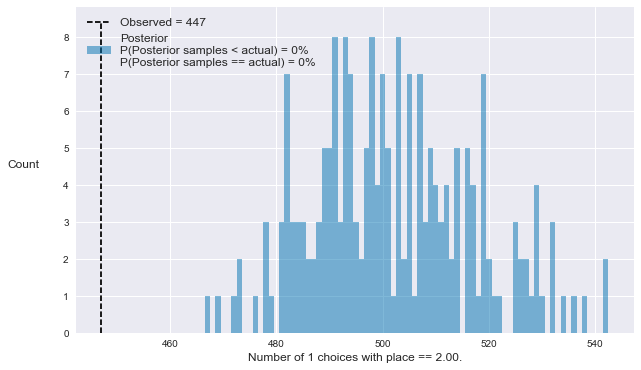

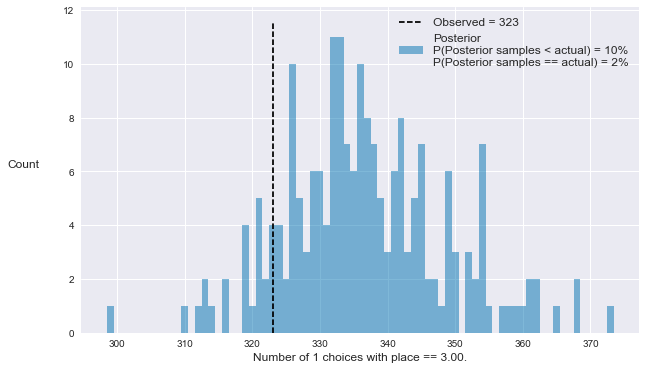

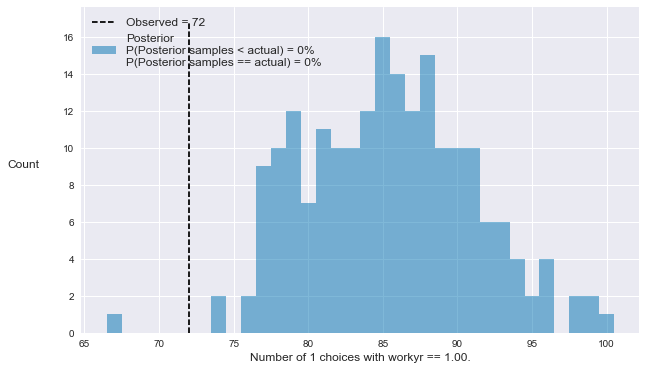

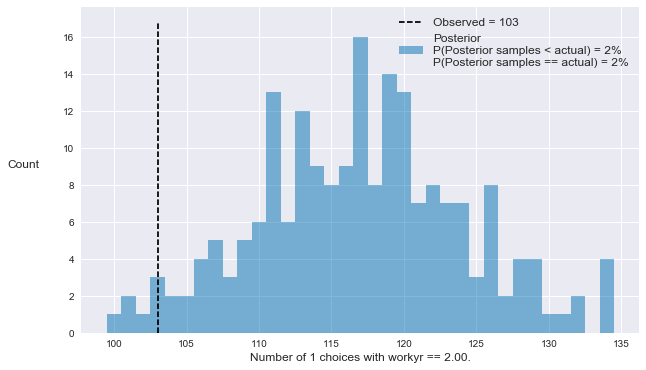

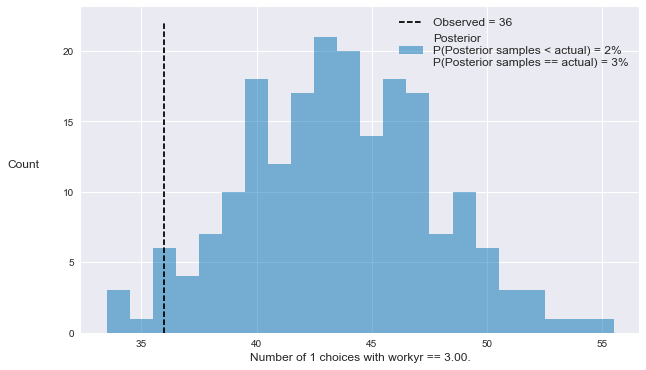

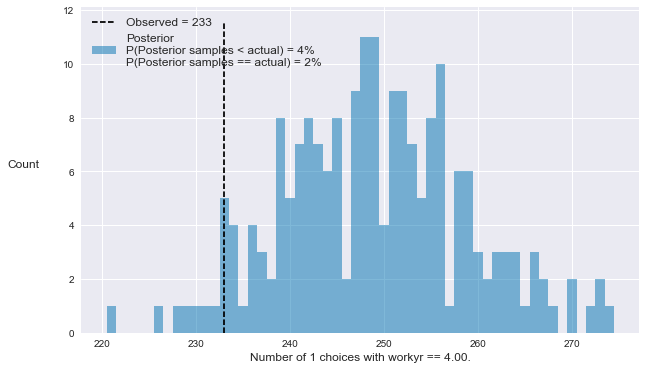

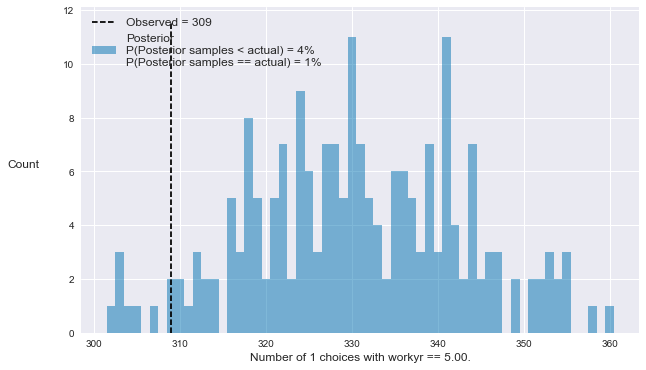

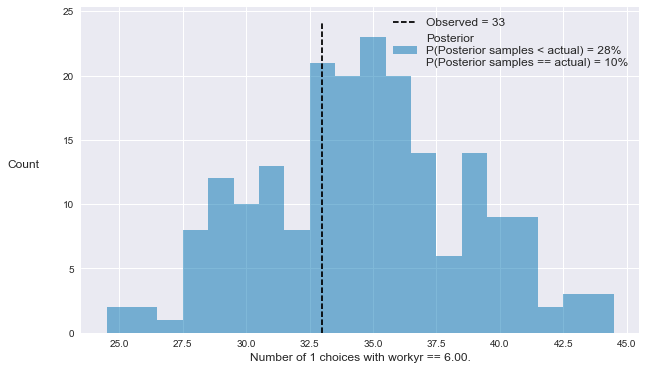

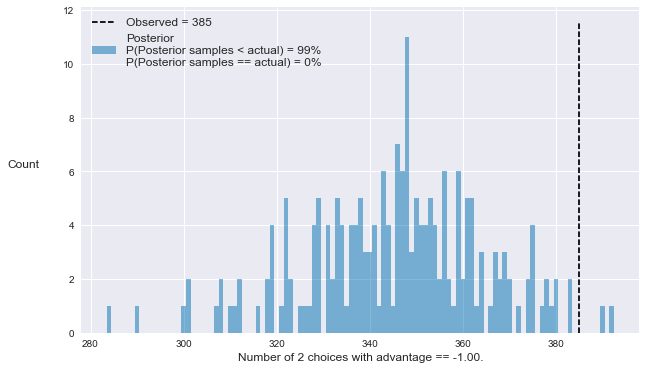

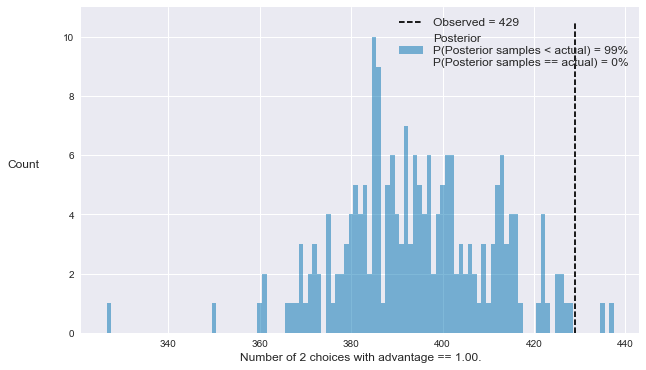

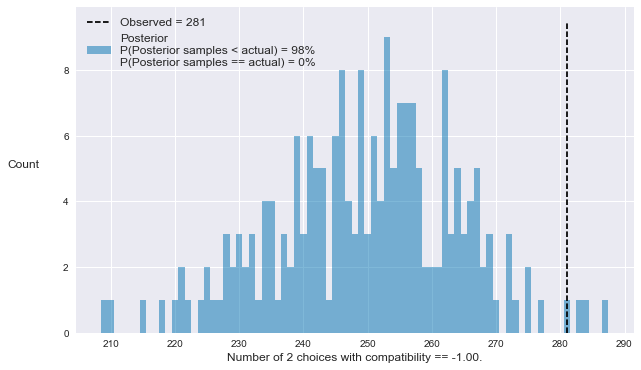

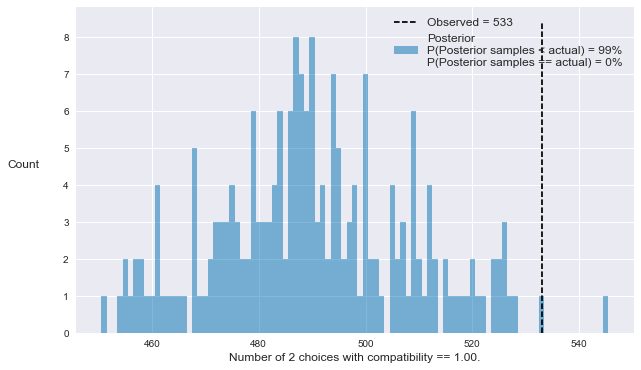

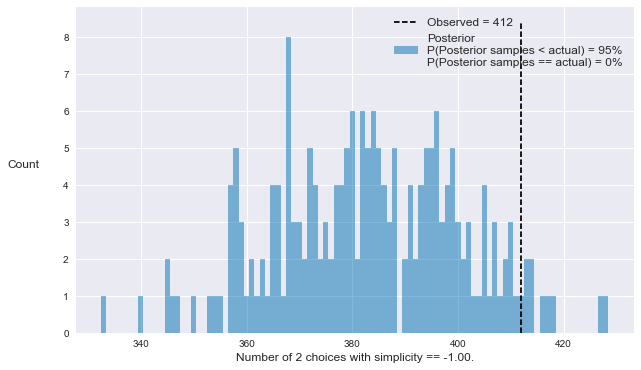

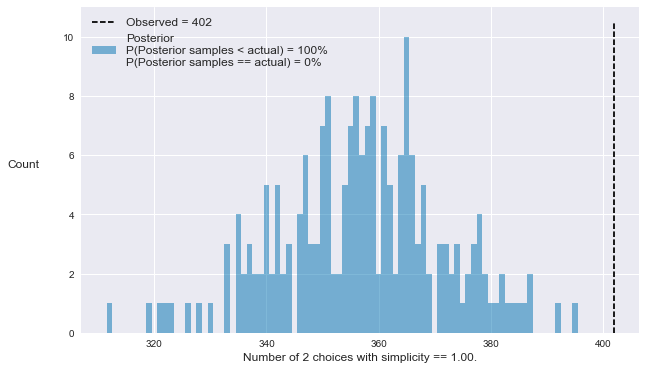

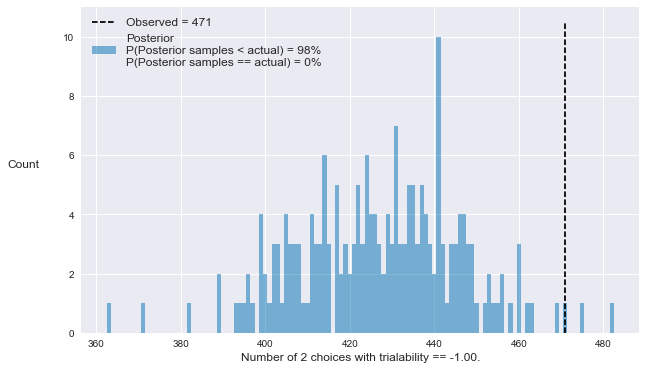

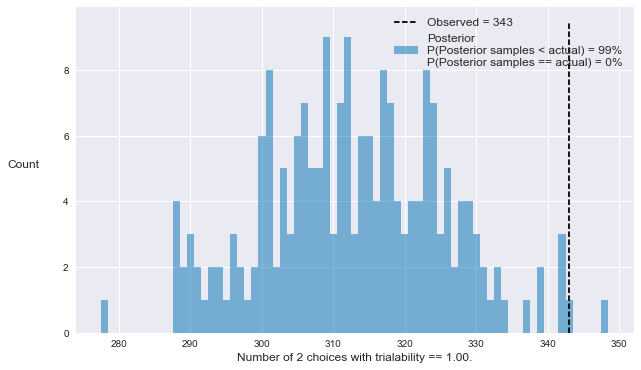

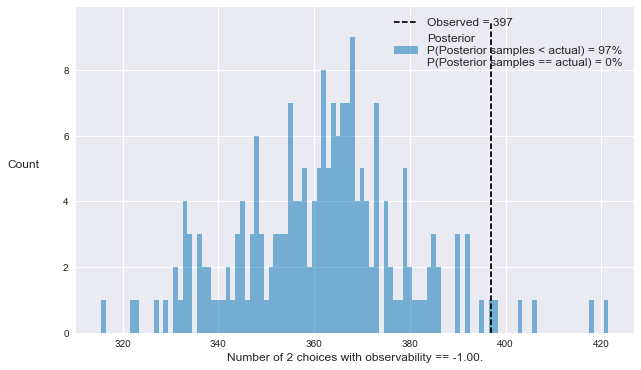

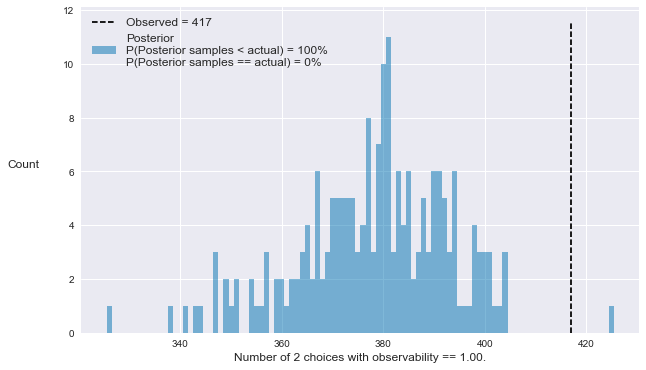

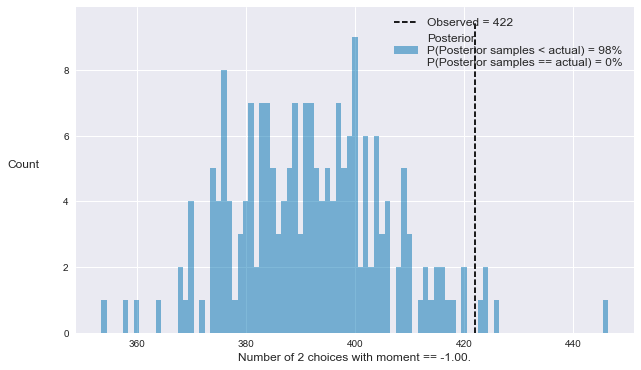

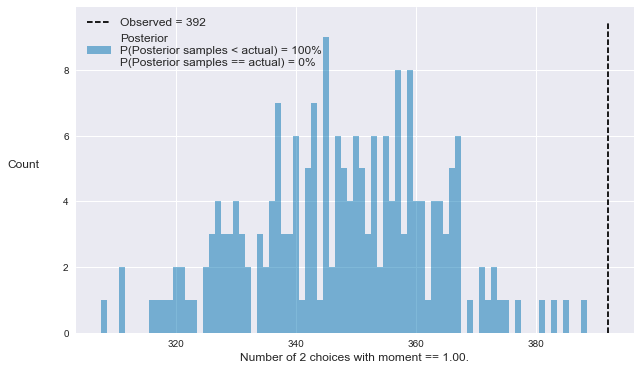

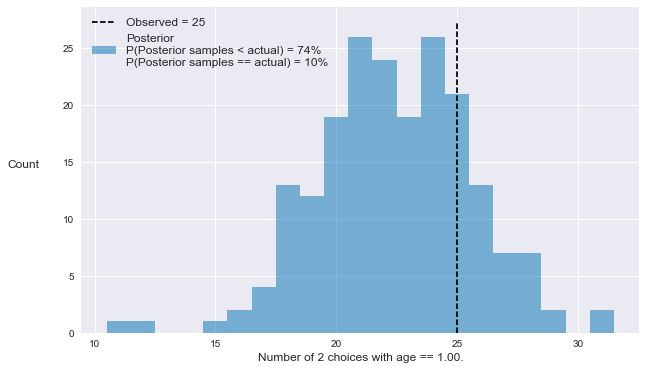

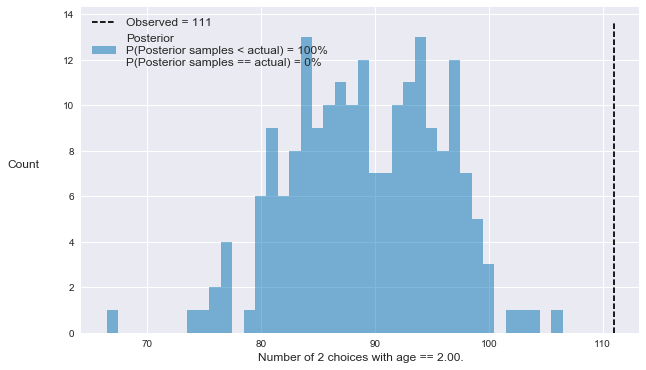

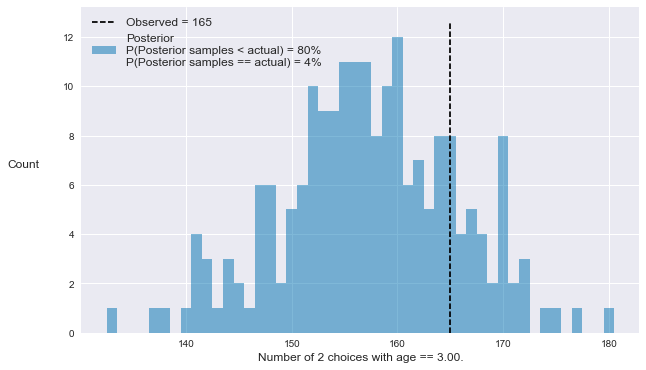

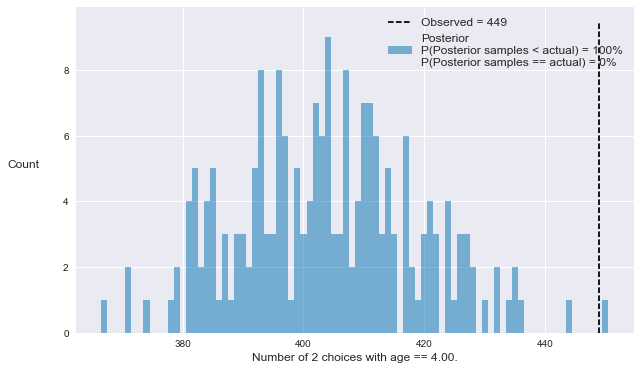

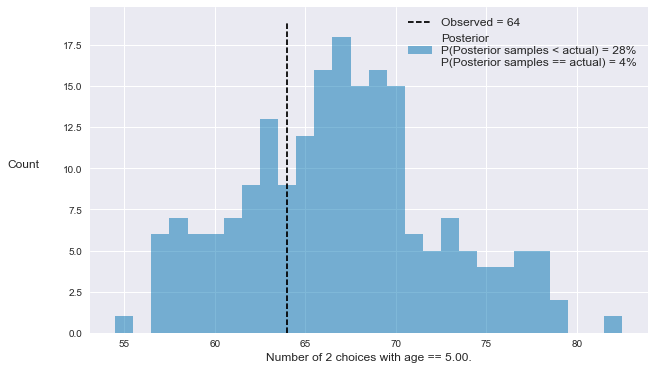

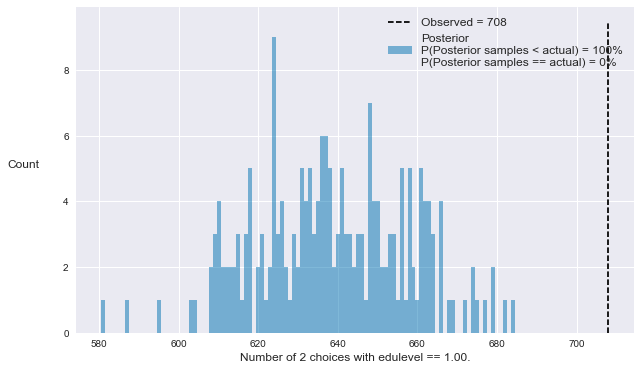

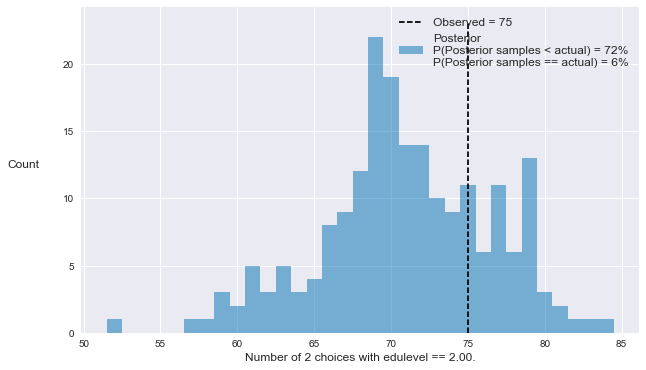

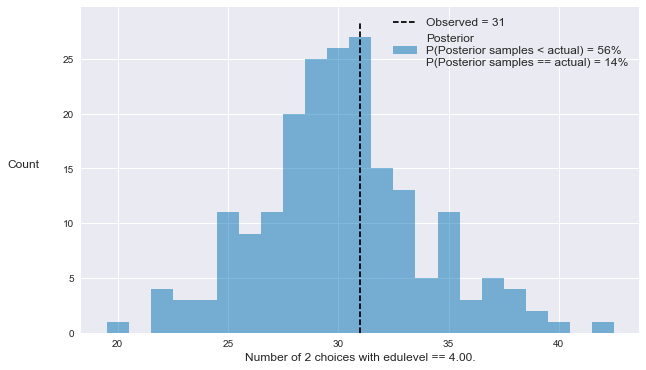

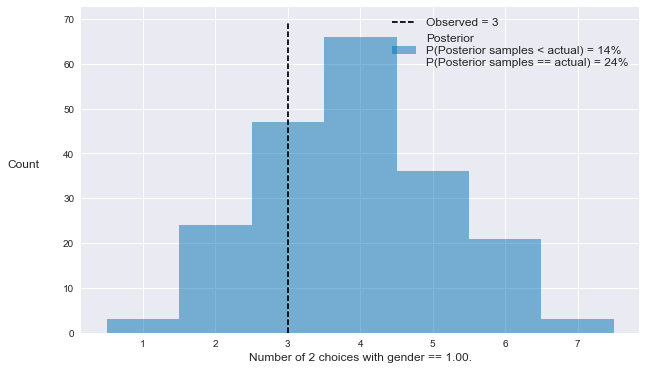

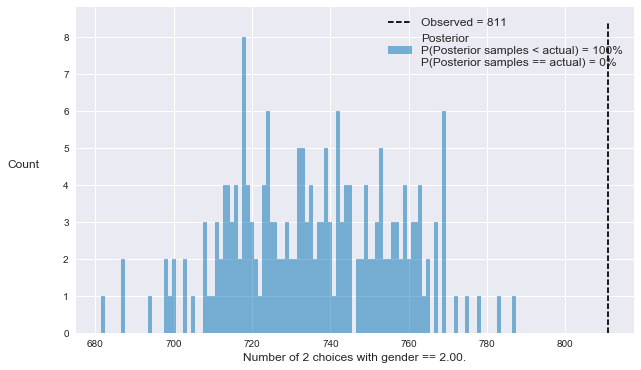

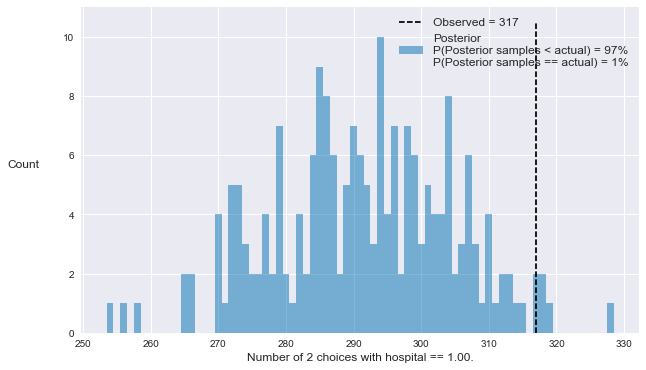

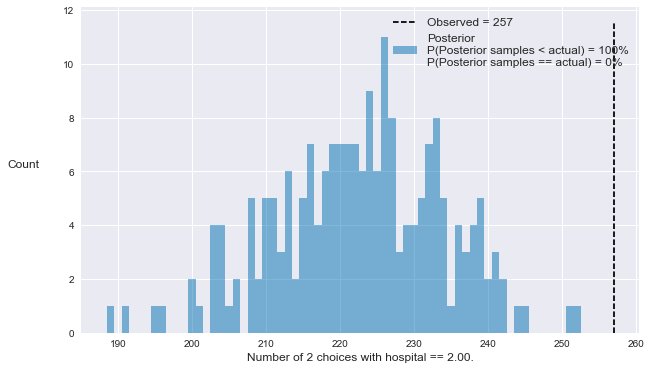

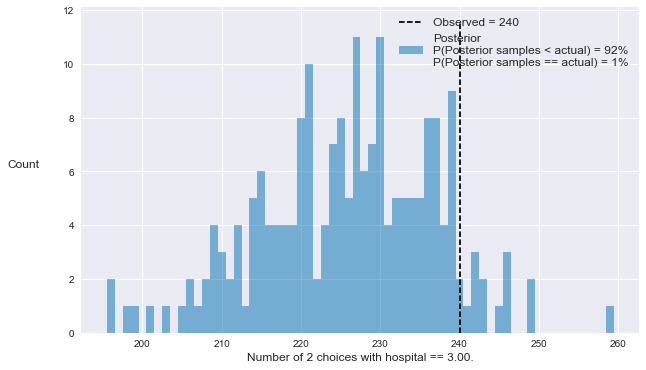

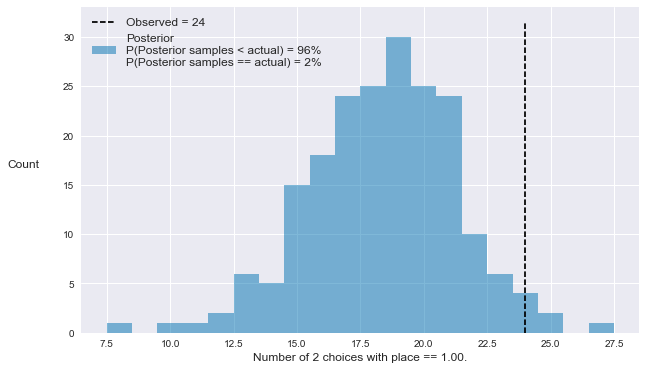

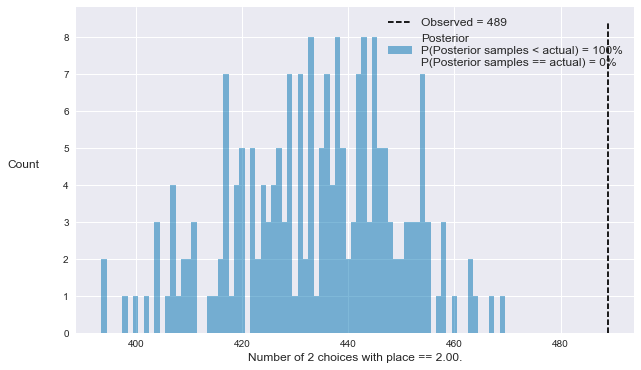

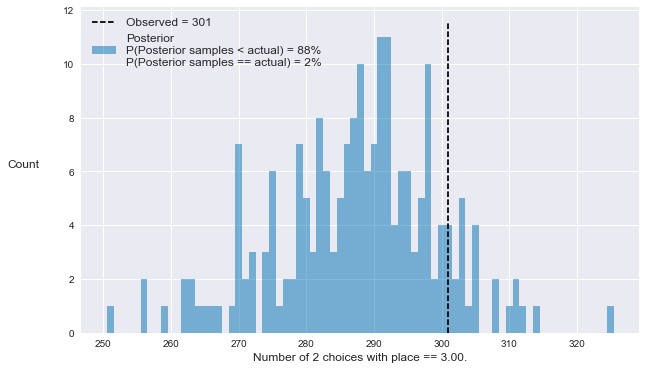

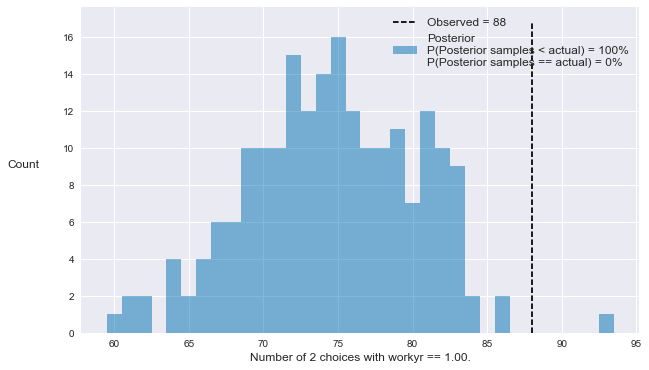

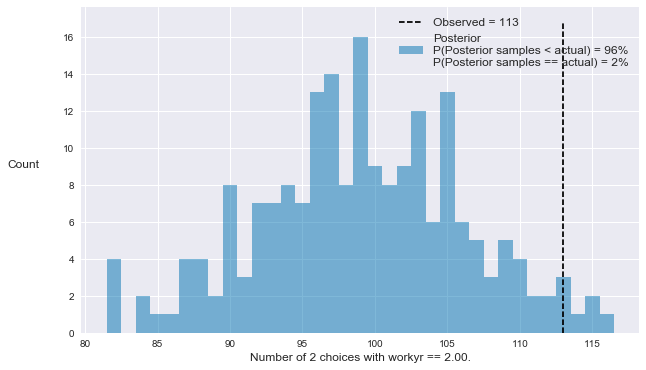

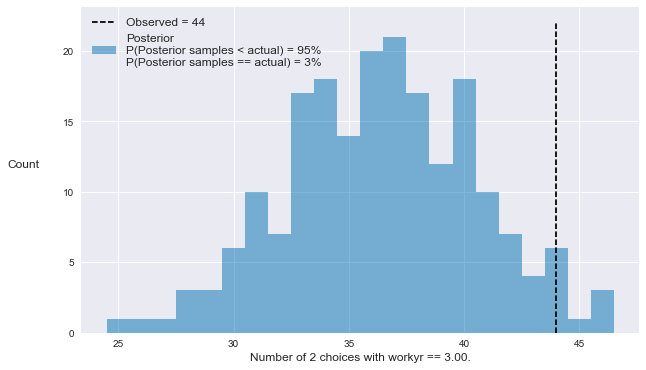

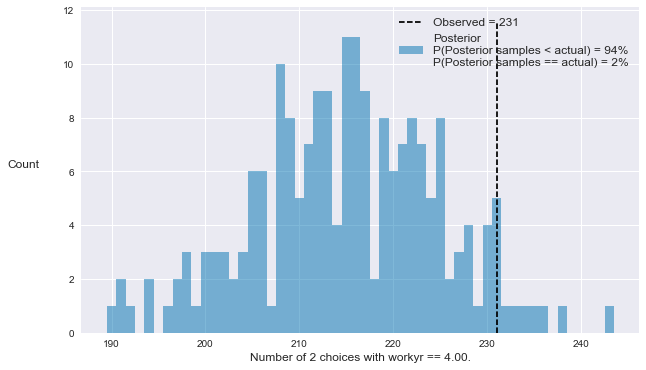

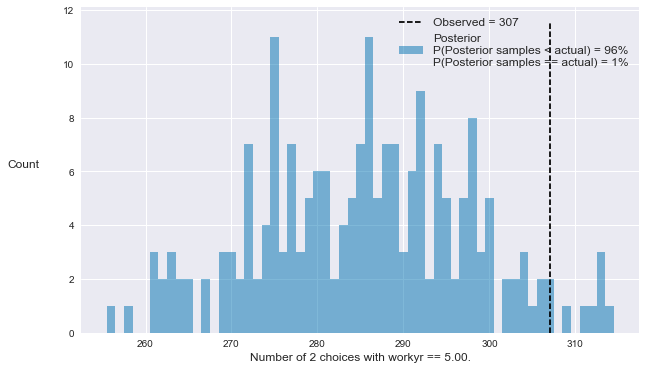

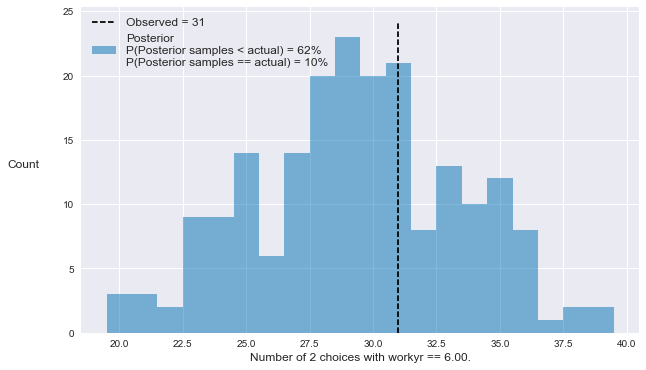

In [32]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    alt_name = alt_id_reverse_map[alt]
    current_filter_name = '{} choices'.format(alt_name)
    current_title = ''

    for current_col in categorical_variables:
        viz.plot_categorical_predictive_densities(
            clean_df,
            None,
            model_checker.sim_y,
            current_col,
            current_filter,
            model_checker.model.choices.astype(int),
            title=current_title,
            filter_name=current_filter_name,
            post_color=sbn.color_palette('colorblind')[0],
            figsize=(10, 6),
            legend_loc='best',
            output_file=filename)

###  10. Simulated Lagrange Multiplier tests for mixing

### Generate artificial variables for Lagrange Multiplier Checks of the interaction model
Note that this is based on the Lagrange Multiplier tests described in McFadden, D., Train, K., 2000. Mixed MNL Models for Discrete Response. Journal of Applied Econometrics 15, 447–470.

In [33]:
# Get the rows_to_obs matrix
rows_to_obs = model_obj.get_mappings_for_fit()['rows_to_obs']

# Get the mean attribute values for each observation
probs_to_obs = rows_to_obs.multiply(model_obj.long_fitted_probs[:, None])

# Will have shape (num_obs, design[1])
x_mean_per_obs = probs_to_obs.T.dot(model_obj.design)

# Will have same shape as the design matrix
long_x_mean_per_obs = rows_to_obs.dot(x_mean_per_obs)

# X - X_mean_per_obs
augmented_x = model_obj.design - long_x_mean_per_obs

# z = 0.5 * (x - x_bar)^2
artificial_x = 0.5 * augmented_x**2

### Make the desired plots

Plotting: 100%|██████████| 200/200 [00:26<00:00,  7.37it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.28it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.26it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 200/200 [00:27<00:00,  7.15it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: Us

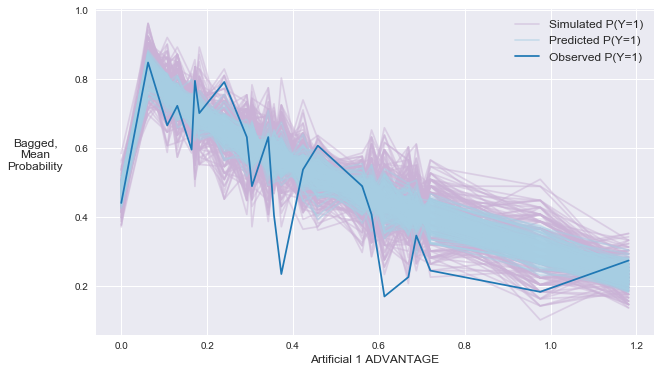

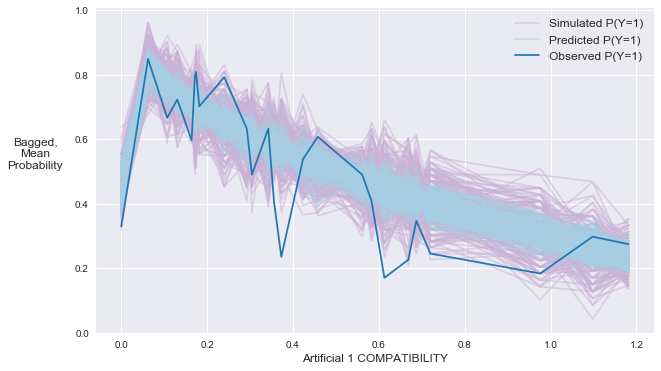

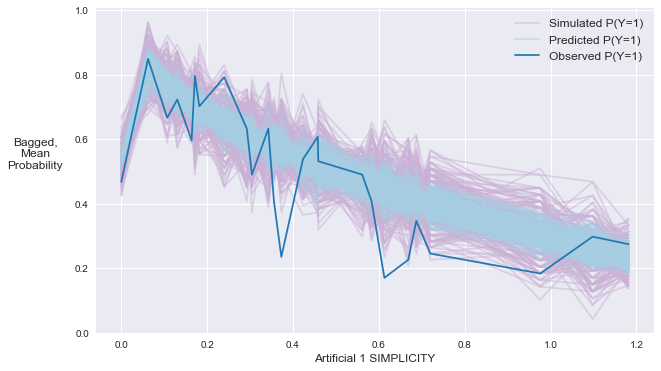

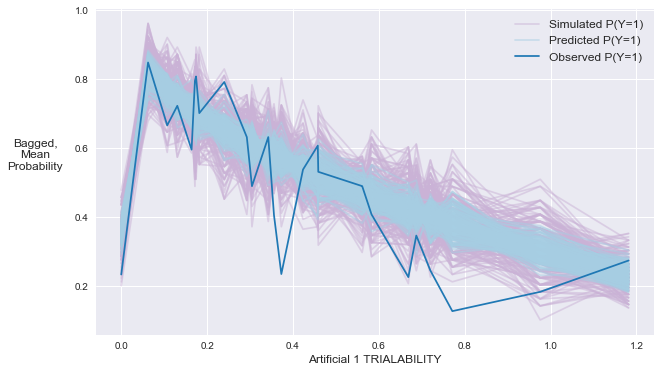

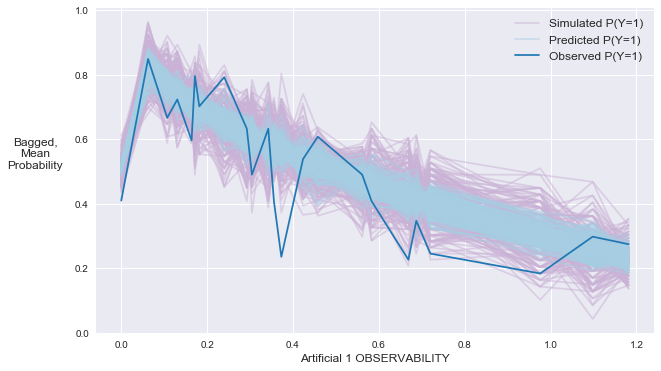

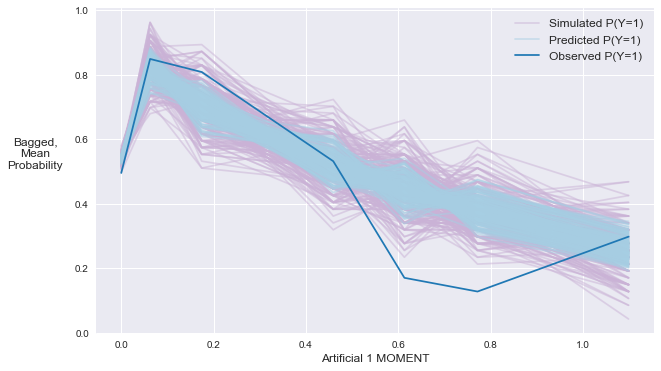

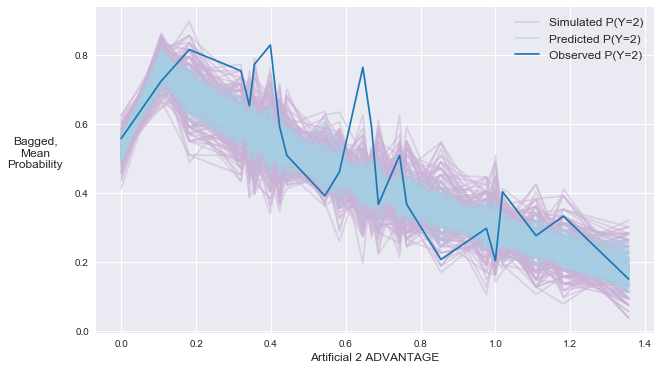

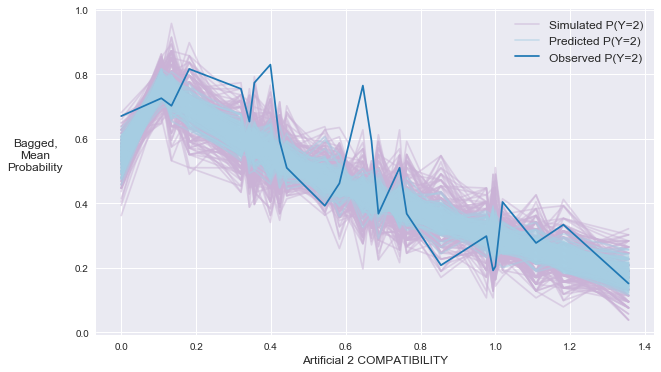

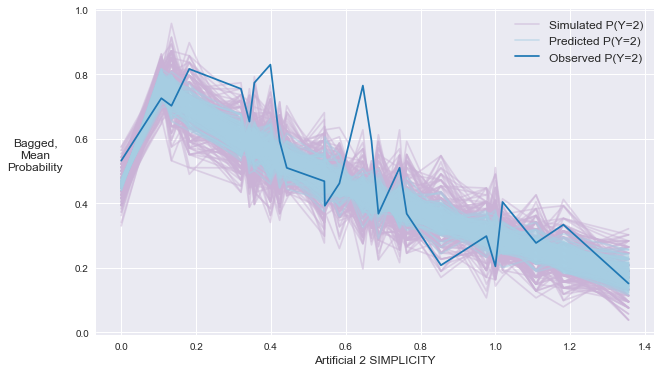

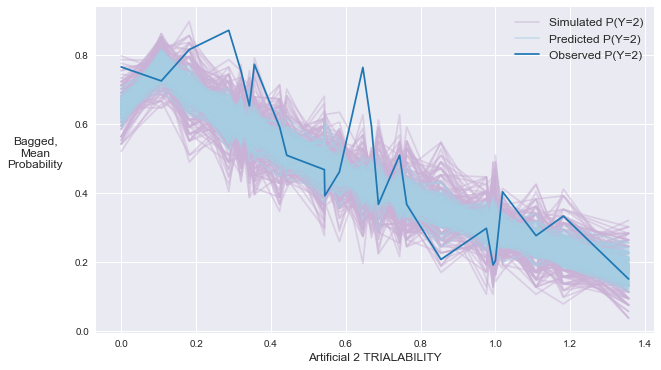

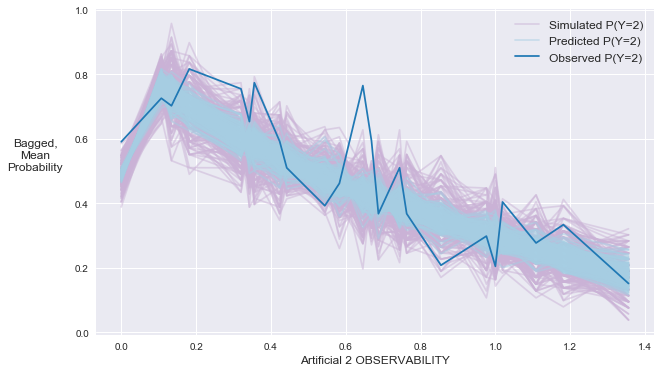

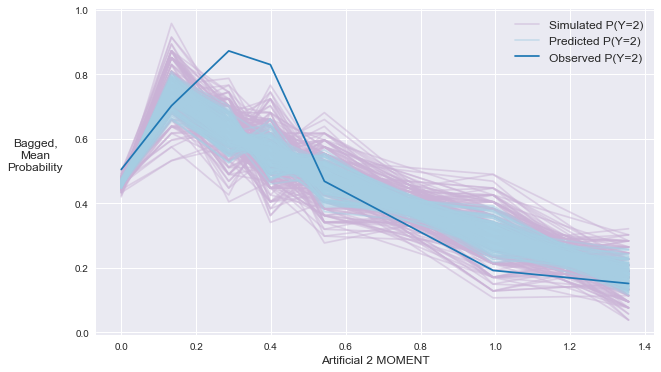

In [34]:
filename = None
for alt in np.sort(np.unique(model_checker.model.alt_IDs)):
    current_filter = model_checker.model.alt_IDs == alt
    alt_name = alt_id_reverse_map[alt]
    current_filter_name = '{} choices'.format(alt_name)
    current_title = '' 

    current_probs =\
        model_checker.posterior_probs[current_filter]
    current_choices =\
        model_checker.model.choices[current_filter]
    current_sim_y = model_checker.sim_y[current_filter, :]
    
    current_y_label = 'Observed P(Y={})'.format(alt_name)
    current_prob_label = 'Predicted P(Y={})'.format(alt_name)
    current_sim_label = 'Simulated P(Y={})'.format(alt_name)
    
    for col in range(model_checker.model.design.shape[1]):
        column_name = (model_checker.model
                                          .params
                                          .index
                                          .tolist()[col])
        current_x = artificial_x[current_filter, col]
        current_x_label =\
            'Artificial {} {}'.format(alt_name, column_name)


        viz.make_bagged_marginal_model_plot(
            current_probs,
            current_choices,
            current_x,
            sim_y=current_sim_y,
            y_label=current_y_label,
            prob_label=current_prob_label,
            sim_label=current_sim_label,
            x_label=current_x_label,
            alpha=0.5,
            figsize=(10, 6))

# Findings and Recommendations based on the posterior predictive checks

1. The posterior predictive checks indicate great model mis-specification for "Alternative 1" and "Alternative 2". This misfit is reiterated in the various predictive performance plots, the market share plots, the reliability plots, as well as the simulated histograms for these alternatives. Basically, "Alternative 1" is systematically over-predicted and "Alternative 2" is systematically under-predicted.
2. An alternative specific constant is likely needed for "Alternative 1" or "Alternative 2".
3. Based on the Lagrange Multiplier checks, a mixed logit specification may perhaps be necessary for some variables. However, I think this may just be an artifact of having all the predicted probabilities for those two alternatives be systematically over/under-estimated.